In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt
import xarray


#warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
#############################################################
os.chdir('D:/Xanthos-Repo/Data')

basinName = pd.read_csv('BasinNames235.txt')
basin_id = pd.read_csv('basin.csv')
#GRDC_xanthosCoordIndx = pd.read_csv('/project/hli/gabeshu/Guta_Working/Basins_Result/UScells/inputs/GRDC_xanthosCoordIndx.csv')
GRDC_xanthosCoordIndx = pd.read_csv('GRDC_stations_list.csv')


basins91 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_91 = [basinName['Basin_Name'][basins91[ii] - 1] for ii in range(GRDC_xanthosCoordIndx.shape[0])]
grdc_basin_m3persec  =  pd.read_csv('grdc_91basin_m3persec_1971_1990_monthly.csv')

file_dir_hp_st = 'D:\\Xanthos-Repo\\Data\\Simulated\\SimulatedFinal-HPx\\reservoir\\'
file_dir_fc_st = 'D:\\Xanthos-Repo\\Data\\Simulated\\SimulatedFinal-FCx\\reservoir\\'
file_dir_hp_rs = 'D:\\Xanthos-Repo\\Data\\Simulated\\SimulatedFinal-HPx\\reservoirRelease\\'
file_dir_fc_rs = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-FCx\\reservoirRelease\\'
dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'

In [3]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

## Storage

In [4]:
reservoirs_halfDegree = xarray.open_dataset('Xanthos_reservoirs_halfDegree_global.nc')
ppose = reservoirs_halfDegree.Main_Use.values
Capacity = reservoirs_halfDegree.Capacity.values
Basin = reservoirs_halfDegree.Basin.values
# get grid indices for the current basin
basin_num = 48
datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
basin_idx = np.squeeze(datad) 

ppose_df = ppose[basin_idx]
Capacity_df = Capacity[basin_idx]

ppose_dfbasin = ppose_df[ppose_df>0]
capacity_dfbasin = Capacity_df[ppose_df>0]
#indx_basin = np.where(ppose_dfbasin==1)[0]

In [5]:
Lon = reservoirs_halfDegree.Lon.values
Lat = reservoirs_halfDegree.Lat.values
Xanthos_Catch_SKM = reservoirs_halfDegree.Xanthos_Catch_SKM.values
datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
basin_idx = np.squeeze(datad) 
basin_idx = basin_idx[basin_idx>0]
# reservoirs properties for grids u/s of GRDC sites
ppose_allgrid = ppose[basin_idx]
capac_allgrid = Capacity[basin_idx]
Lon_allgrids = Lon[basin_idx]
Lat_allgrdis = Lat[basin_idx]
da_allgrids = Xanthos_Catch_SKM[basin_idx]
# reservoir grids
ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
capac_basin = capac_allgrid[(ppose_allgrid>0)]
Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

# get HP reservoirs grid us/s for GRDC
ppose_HP = ppose_basin[((ppose_basin==1) | (ppose_basin==3))]
capac_HP = capac_basin[((ppose_basin==1) | (ppose_basin==3))]*1e-3
Lon_HP = Lon_basin[((ppose_basin==1) | (ppose_basin==3))]
Lat_HP = Lat_basin[((ppose_basin==1) | (ppose_basin==3))]

(<matplotlib.legend.Legend at 0x13ec1f8deb0>,
 <matplotlib.legend.Legend at 0x13ec1fce970>)

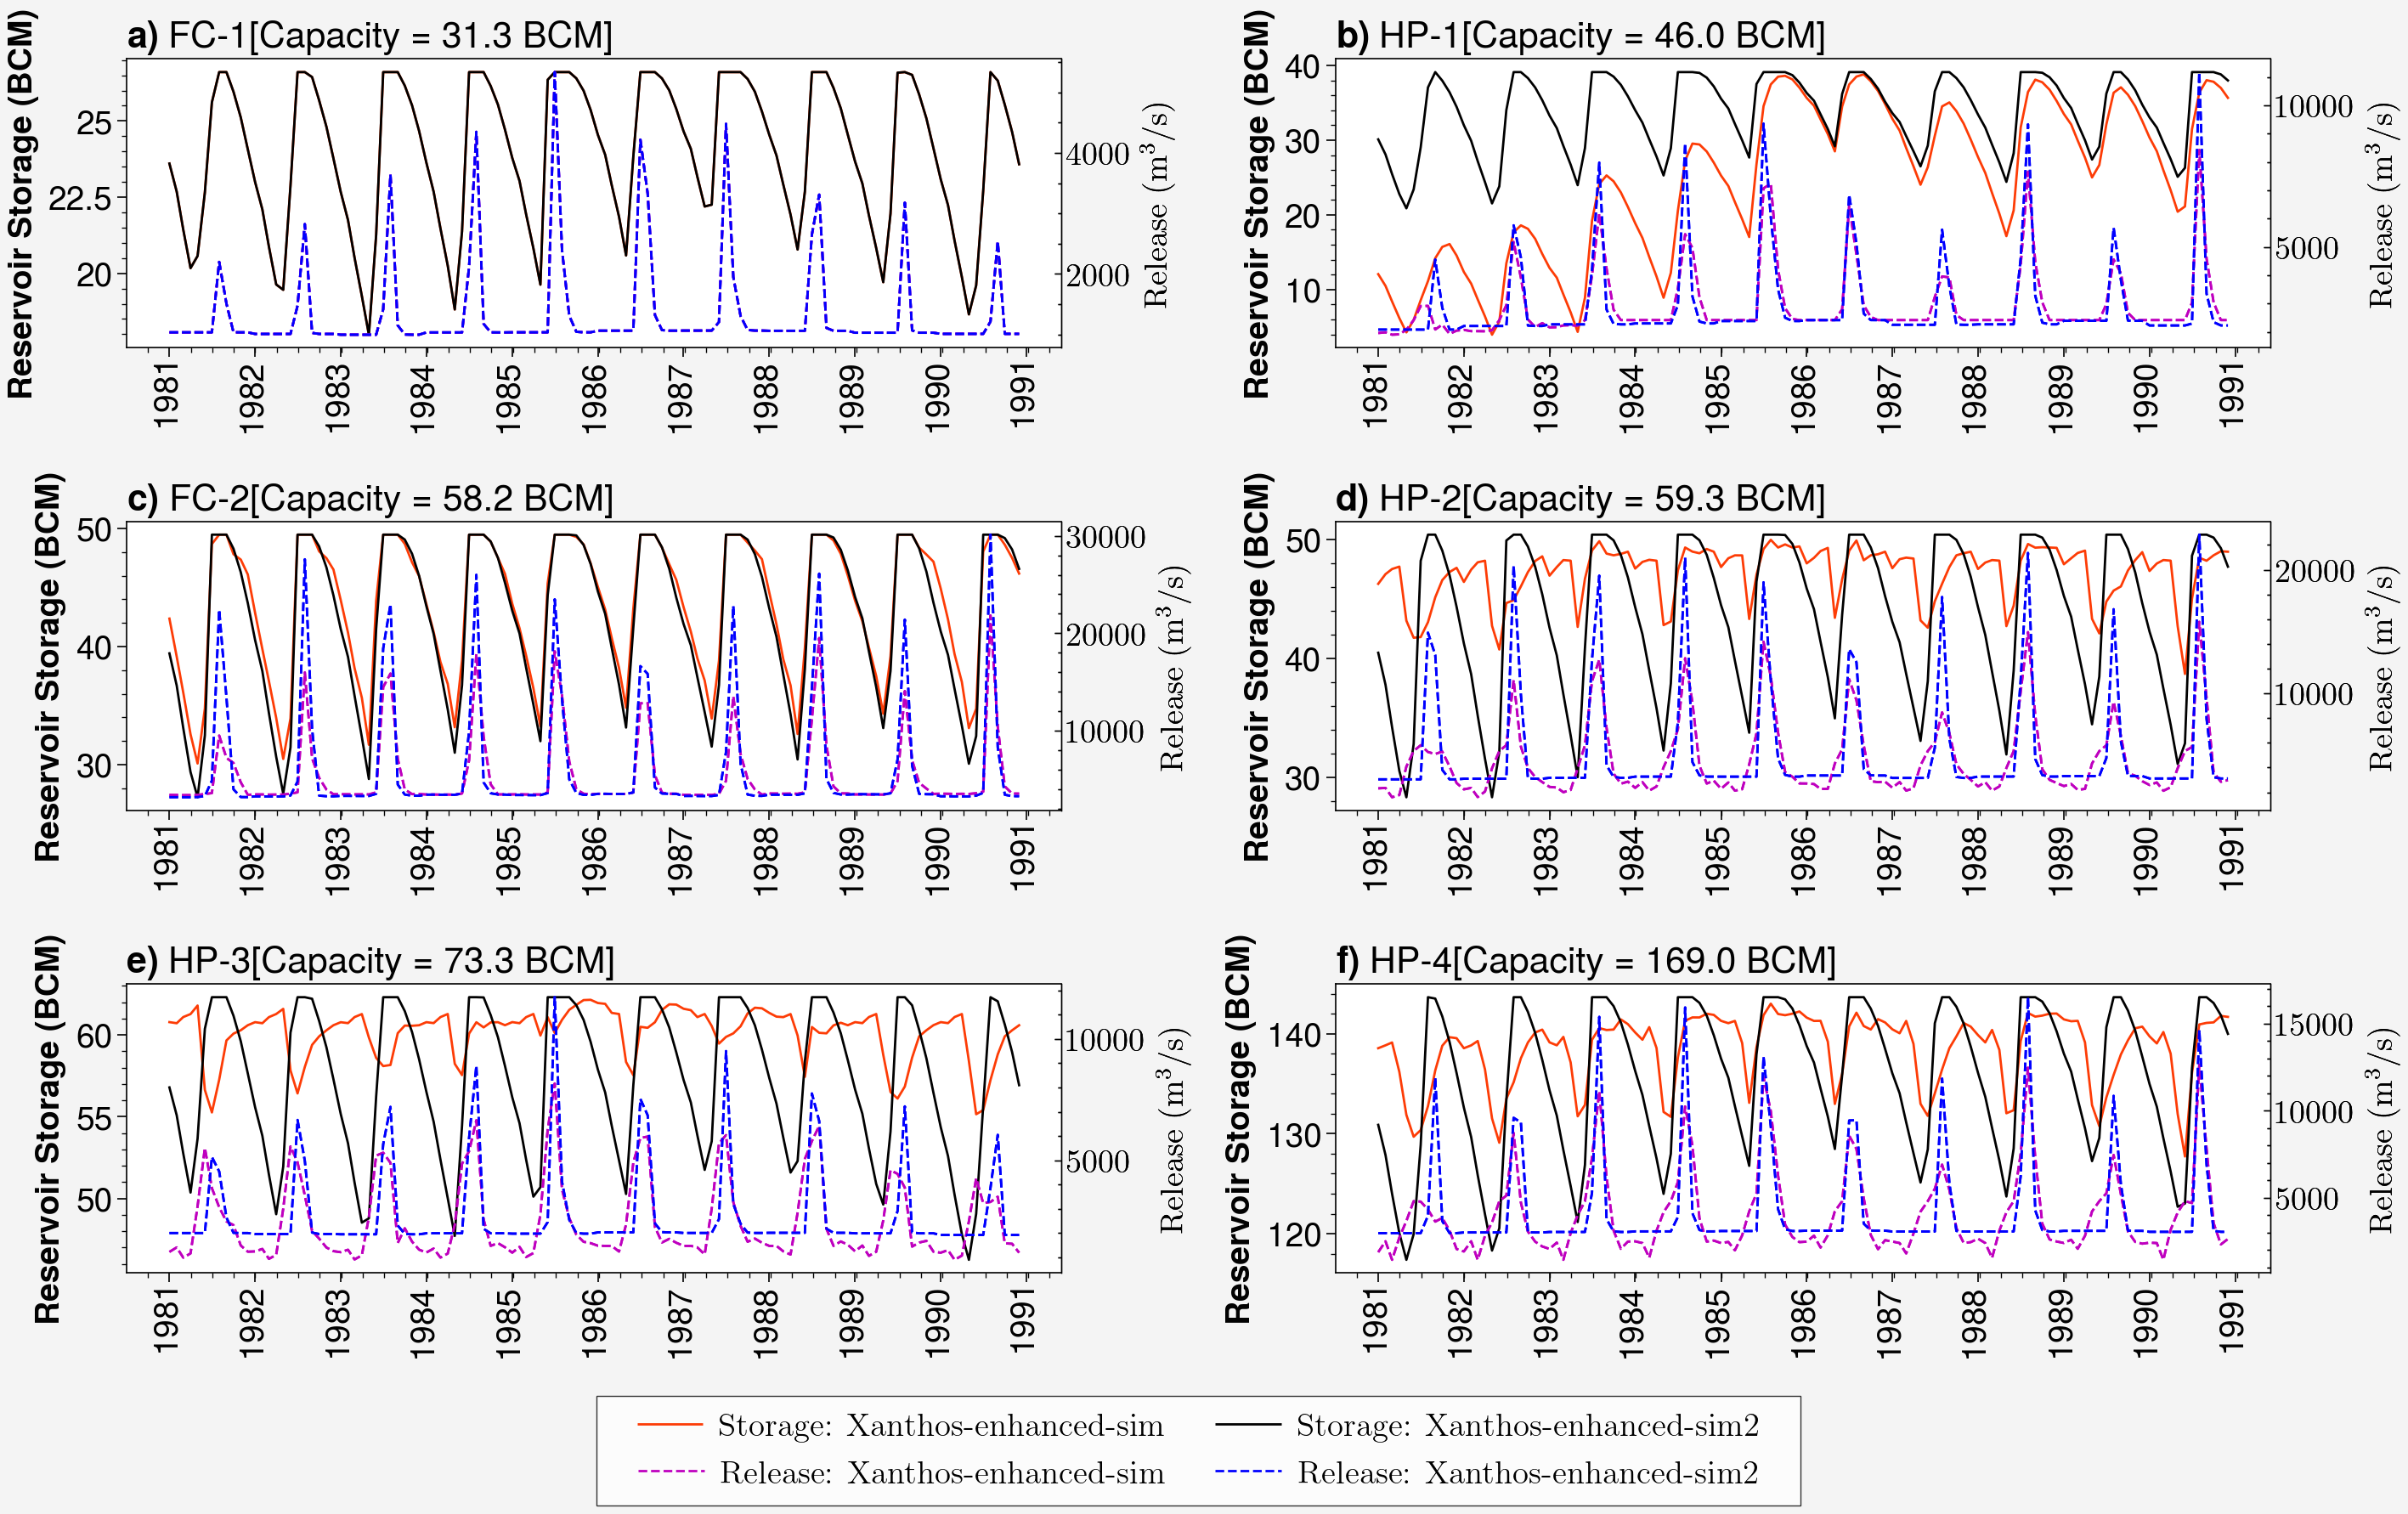

In [6]:

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 14, 'font.weight':'bold'}) 
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'


SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
fig, axs = pplt.subplots(ncols=2, nrows=3,refaspect=1, refheight=1.70, refwidth=5.50, share=0)

capac_HP = np.round(capac_basin[(ppose_dfbasin==1) | (ppose_dfbasin==3)]*1e-3, 2)
#fig, axs = pplt.subplots(ncols=2, nrows=3,refaspect=1, refheight=2.0, refwidth=5.0, share=0)

indx_basin = np.where((ppose_dfbasin==1) | (ppose_dfbasin==3))[0]

sort_index = np.argsort(capac_HP)
title_label = ['FC-1', 'HP-1','FC-2','HP-2','HP-3','HP-4']

storage_column = [0, 2, 4, 6, 8, 10]
release_column = [1, 3, 5, 7, 9, 11]

plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):

    ## simulated storage
    data_basin_hp_st = np.load(file_dir_hp_st + 'SimReservoirs_' + str(basin_num) + '.npy') 
    data_basin_fc_st = np.load(file_dir_fc_st + 'SimReservoirs_' + str(basin_num) + '.npy')   
    ## simulated release
    data_basin_hp_rs = np.load(file_dir_hp_rs + 'ReservoirsRelease_' + str(basin_num) + '.npy') 
    data_basin_fc_rs = np.load(file_dir_fc_rs + 'ReservoirsRelease_' + str(basin_num) + '.npy')   
 
    for jj in range(indx_basin.shape[0]):
        ii = sort_index[jj]
        mm = sort_index[jj]
        # with hydropower
        rsim_hp= data_basin_hp_st[mm,:]*1e-9
        rsim_HPts = timeseries_coverter(rsim_hp[120:240], start_yr=1981, ending_yr=1990)
        # with flood control
        rsim_fc= data_basin_fc_st[mm,:]*1e-9
        rsim_FCts = timeseries_coverter(rsim_fc[120:240], start_yr=1981, ending_yr=1990)
        
        # plot
        ax=axs[jj]  
        #fig, ax = pplt.subplots(ncols=1, nrows=1,refaspect=1, refheight=2.0, refwidth=5.0, share=0)
        hs = ax.plot(rsim_HPts,'red orange', linewidth=1.0, linestyle='-', label='Storage: Xanthos-enhanced-sim')   
        hs1 = ax.plot(rsim_FCts, 'k', linewidth=1.0, label='Storage: Xanthos-enhanced-sim2')
        hs.append(hs1)        
        if  ppose_dfbasin[mm]==1:
            ax.format(ylabel = 'Reservoir Storage (BCM)', title=title_label[jj] + '[' + 'Capacity = ' +str(capac_HP[ii]) +' BCM]', grid=False, abcstyle='a)', titleloc='l')
        elif  ppose_dfbasin[mm]==3:
            ax.format(ylabel = 'Reservoir Storage (BCM)', title=title_label[jj] + '[' + 'Capacity = ' +str(capac_HP[ii]) +' BCM] ', grid=False, abcstyle='a)', titleloc='l')         
        #ax.set_ylim([0,max(rsim_)])
        #plt.show()
        kge_v2 = spotpy.objectivefunctions.kge(rsim_fc[0:240], rsim_hp[0:240])
        #print(kge_v2)
        #if jj==5:
        #    ax.legend(ncols=1)

        ################################################################################
        # with hydropower
        rsim_hp= data_basin_hp_rs[mm,:]
        rsim_HPts = timeseries_coverter(rsim_hp[120:240], start_yr=1981, ending_yr=1990)
        # with flood control
        rsim_fc= data_basin_fc_rs[mm,:]
        rsim_FCts = timeseries_coverter(rsim_fc[120:240], start_yr=1981, ending_yr=1990)
        
        # plot
        ax2=ax.twinx()
        #fig, ax = pplt.subplots(ncols=1, nrows=1,refaspect=1, refheight=2.0, refwidth=5.0, share=0)
        hs2 = ax2.plot(rsim_HPts, 'm',linewidth=1.0, linestyle='dashed', label='Release: Xanthos-enhanced-sim')  
        hs.append(hs2)    
        hs3 = ax2.plot(rsim_FCts, 'b',linewidth=1.0, linestyle='dashed', label='Release: Xanthos-enhanced-sim2') 
        hs.append(hs3)     
        ax2.format(ylabel = 'Release (m' + r'$^{3}$' + '/s)',grid=False )      
        #ax.set_ylim([0,max(rsim_)])
        #plt.show()
        kge_v2 = spotpy.objectivefunctions.kge(rsim_fc[0:240], rsim_hp[0:240])
        #print(kge_v2)
        #if jj==1:
        #    ax.legend(ncols=1, loc='ul')


plt.tight_layout()
fig.legend(hs, ncols=2, center=True, frame=True, loc='b', fontsize=12)

#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig(dir_out + "Figure-15.png", **SAVE_KWDS)   